In [1]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

In [2]:
import numpy as np
Chem = np.load('../data/chem-network.npy')
Gap = np.load('../data/gap-network.npy')
neuron_ids = np.load('../data/neurons.npy')
neuron_types = np.load('../data/neuron-types.npy')

In [3]:
A = Chem + Gap
C = (A + A.T) / 2

In [4]:
degrees = np.sum(C, axis=0)
D = np.diag(degrees)

In [5]:
L = D - C

In [6]:
from scipy import linalg
b = np.sum(C * np.sign(A - A.T), axis=1)
z = linalg.pinv(L) @ b

In [7]:
Dinv2 = np.diag(1 / np.sqrt(degrees))
Q = Dinv2 @ L @ Dinv2

In [8]:
val, Vec = linalg.eig(Q)

In [9]:
smallest_first = np.argsort(val)
val = val[smallest_first]
Vec = Vec[:, smallest_first]

In [10]:
x = Dinv2 @ Vec[:, 1]

In [11]:
vc2_index = np.argwhere(neuron_ids == 'VC02')
if x[vc2_index] < 0:
    x = -x

In [12]:
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection


def plot_connectome(x_coords, y_coords, conn_matrix, *,
                    labels=(), types=None, type_names=('',),
                    xlabel='', ylabel=''):
    """Plot neurons as points connected by lines.

    Neurons can have different types (up to 6 distinct colors).

    Parameters
    ----------
    x_coords, y_coords : array of float, shape (N,)
        The x-coordinates and y-coordinates of the neurons.
    conn_matrix : array or sparse matrix of float, shape (N, N)
        The connectivity matrix, with nonzero entry (i, j) if and only
        if node i and node j are connected.
    labels : array-like of string, shape (N,), optional
        The names of the nodes.
    types : array of int, shape (N,), optional
        The type (e.g. sensory neuron, interneuron) of each node.
    type_names : array-like of string, optional
        The name of each value of `types`. For example, if a 0 in
        `types` means "sensory neuron", then `type_names[0]` should
        be "sensory neuron".
    xlabel, ylabel : str, optional
        Labels for the axes.
    """
    if types is None:
        types = np.zeros(x_coords.shape, dtype=int)
    ntypes = len(np.unique(types))
    colors = plt.rcParams['axes.prop_cycle'][:ntypes].by_key()['color']
    cmap = ListedColormap(colors)

    fig, ax = plt.subplots()

    # plot neuron locations:
    for neuron_type in range(ntypes):
        plotting = (types == neuron_type)
        pts = ax.scatter(x_coords[plotting], y_coords[plotting],
                         c=cmap(neuron_type), s=4, zorder=1)
        pts.set_label(type_names[neuron_type])
    # add text labels:
    for x, y, label in zip(x_coords, y_coords, labels):
        ax.text(x, y, '   ' + label,
                verticalalignment='center', fontsize=3, zorder=2)

    # plot edges
    pre, post = np.nonzero(conn_matrix)
    links = np.array([[x_coords[pre], x_coords[post]],
                      [y_coords[pre], y_coords[post]]]).T
    ax.add_collection(LineCollection(links, color='lightgray',
                                     lw=0.3, alpha=0.5, zorder=0))

    ax.legend(scatterpoints=3, fontsize=6)

    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)

    plt.show()

In [13]:
from scipy import sparse
import scipy.sparse.linalg

As = sparse.csr_matrix(A)

In [14]:
Cs = (As + As.T) / 2

In [15]:
degrees = np.ravel(Cs.sum(axis=0))
Ds = sparse.diags(degrees)

In [16]:
Ls = Ds - Cs

In [17]:
b = Cs.multiply((As - As.T).sign()).sum(axis=1)
z, error = sparse.linalg.isolve.cg(Ls, b, maxiter=10000)

In [18]:
Dsinv2 = Ds.copy()
Dsinv2.data = 1 / np.sqrt(Ds.data)

In [19]:
Qs = Dsinv2 @ Ls @ Dsinv2
vals, Vecs = sparse.linalg.eigsh(Qs, k=3, which='SM')
sorted_indices = np.argsort(vals)
Vecs = Vecs[:, sorted_indices]

In [20]:
y = Dinv2 @ Vec[:, 2]
asjl_index = np.argwhere(neuron_ids == 'ASJL')

In [21]:
_dsinv, x, y = (Dsinv2 @ Vecs).T
if x[vc2_index] < 0:
    x = -x
if y[asjl_index] < 0:
    y = -y

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

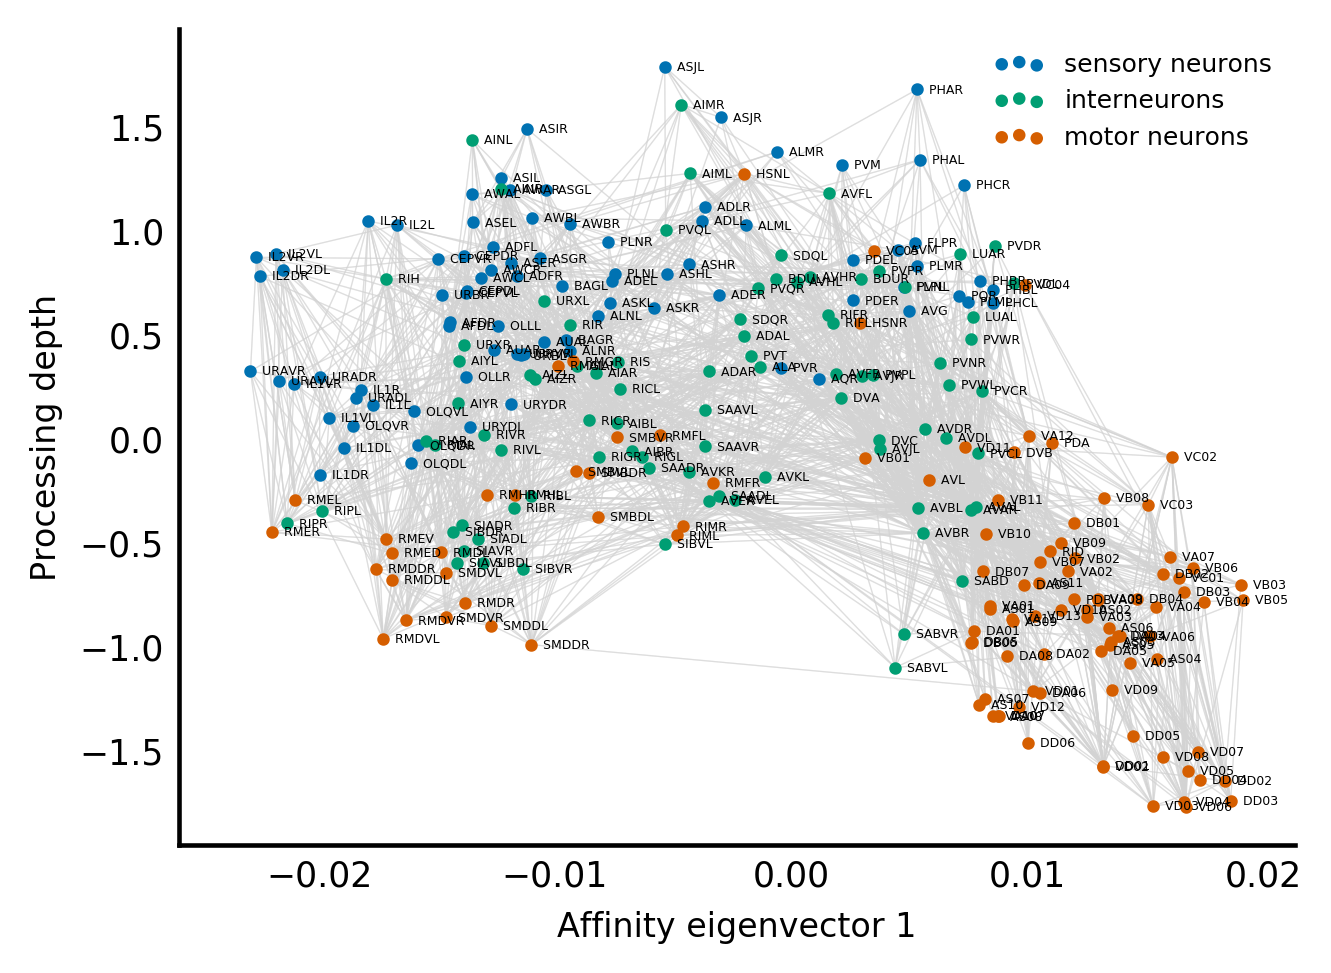

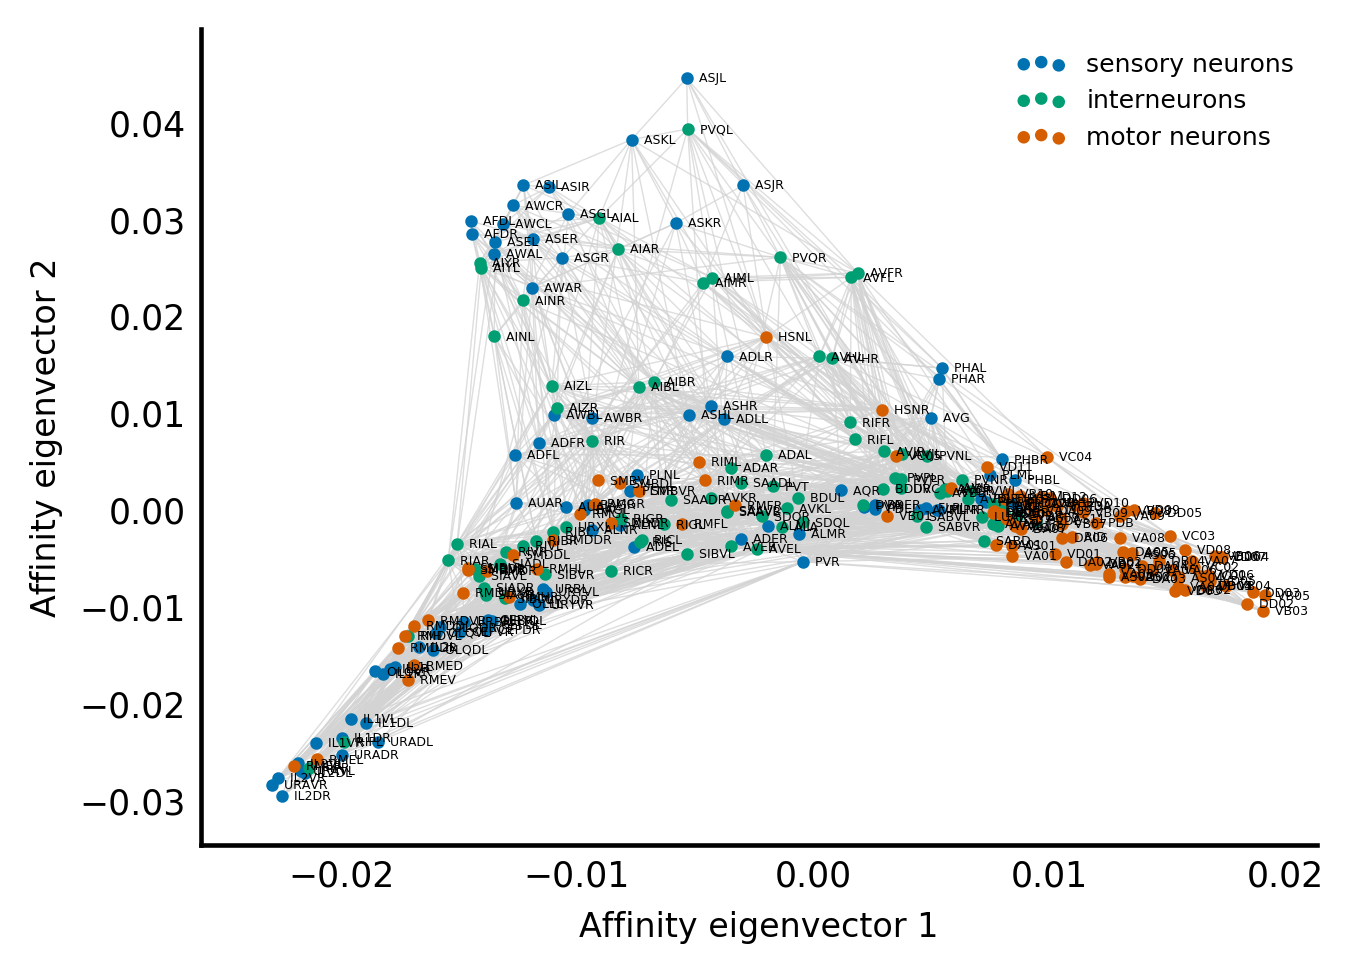

In [22]:
plot_connectome(x, z, C, labels=neuron_ids, types=neuron_types,
                type_names=['sensory neurons', 'interneurons',
                            'motor neurons'],
                xlabel='Affinity eigenvector 1', ylabel='Processing depth')

plot_connectome(x, y, C, labels=neuron_ids, types=neuron_types,
                type_names=['sensory neurons', 'interneurons',
                            'motor neurons'],
                xlabel='Affinity eigenvector 1',
                ylabel='Affinity eigenvector 2')
